# Feature Matrix Optimization on Simulated Preference Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from helpers.helpers_similarity import *
from helpers.helpers_optimization import *
from scipy.optimize import minimize
import time


In [2]:
# Define the parameters for the Gaussian distributions
mu = 0
sigma_u = 1
sigma_v = 1
sigma = 0

# Set the regularization parameter
lambda_reg = 0.1

# Define a dictionary to store parameters
parameters = {}

# Define the dimensionality
d_dim = 2

## Bradley-Terry-Luce (BTL) model

Calculate the difference between each pair of elements in the 2D array X. Then, generate the probability matrix by applying the logistic function $$P(x) = \frac{e^{x}}{1 + e^{x}}$$ element-wise to the difference matrix, where x is the difference between two elements :

In [3]:
def generate_P_BT_Luce(X, n_users, alpha=1.0): 
    """
    Generate P and X_diff matrices using the Bradley-Terry-Luce model.

    Parameters:
    X : Input Matrix.
    n_users : int
        Number of users.
    alpha : float, optional
        Scaling factor (default is 1.0).

    Returns:
    P : Probability matrix.
    X_diff : Difference matrix.
    """
    # Compute the difference matrix
    diff = alpha*np.subtract.outer(X, X) 
    X_diff= np.array([diff[i, :, i, :] for i in range(n_users)])

    # Compute the probability matrix
    P = np.exp(X_diff) / (1 + np.exp(X_diff))
    
    return P, X_diff


Generate pairwise comparison data $Y_{ijk} = \pm 1$ for each user and item. The output Y is a $3D$ tensor with the shape $(n\_users, n\_items, n\_items)$. Each entry $Y[i,j,k]$ corresponds to whether user i prefers item j over item k. For example, line 0 of Y corresponds to the pairwise comparisons of user 0 with all items: $Y[0,0,:]$ represents whether user 0 prefers item 0 over all other items $(item\_0, item\_1, item\_2, etc..)$, and so on.

In [4]:
def pairwise_comparisons(P):
    """
    Generate pairwise comparisons matrix.

    Parameters:
    P : Probability matrix.

    Returns:
    Y : Pairwise comparisons matrix.
    """
    # Generate binomial random numbers based on the probabilities in P
    Y = np.random.binomial(n=1, p=P, size=P.shape) 

    # Replace zeros with -1
    Y = np.where(Y == 0, -1, Y)
    
    return Y


In [5]:
def hinge_loss(x):
    """
    Compute the hinge loss.

    Parameters:
    x : Input array.

    Returns:
    Hinge loss values.
    """
    return np.maximum(0, 1 - x)**2 


In [6]:
def sum_loss(U, V, Y):
    """
    Compute the sum of hinge losses.

    Parameters:
    U : User feature matrix.
    V : item feature matrix.
    Y : pairwise comparisons.

    Returns:
    Total loss.
    """
    n, m, _ = Y.shape
    loss = 0
    for j in range(m):
        v = V[:,j] - V.T
        x = np.dot(v, U)
        loss += np.sum(hinge_loss(Y[:,j]*x.T)[:,:j])
    return loss


In [ ]:
n_users = [10, 20, 40, 80, 160]
times2 = []

# Loop over different numbers of users
for n in n_users:
    # Generate U, V, and X matrices
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n, n)

    # Generate P matrix using the Bradley-Terry-Luce model
    P, _ = generate_P_BT_Luce(X, n)

    # Generate pairwise comparisons matrix
    Y = pairwise_comparisons(P)

    # Measure the time taken to compute the sum of hinge losses
    start = time.time()
    loss = sum_loss(U, V, Y)
    times2.append(time.time() - start)

print(times2)


In [7]:
def loss_U(U, Y, V, lambda_reg, d_dim, n_users):
    """
    Compute the loss with respect to U.

    Parameters:
    U : User feature matrix, reshaped into a 1D array.
    Y : Matrix of pairwise comparisons.
    V : Item feature matrix.
    lambda_reg : Regularization parameter.
    d_dim : Number of dimensions.
    n_users : Number of users.

    Returns:
    Total loss with respect to U.
    """
    U = U.reshape((d_dim, n_users))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(U, 'fro') ** 2 
    
    return loss + reg


In [8]:
def loss_V(V, Y, U, lambda_reg, d_dim, n_movies):
    """
    Compute the loss with respect to V.

    Parameters:
    V : Item feature matrix, reshaped into a 1D array.
    Y : Matrix of pairwise comparisons.
    U : User feature matrix.
    lambda_reg : Regularization parameter.
    d_dim : Number of dimensions.
    n_movies : Number of items.

    Returns:
    Total loss with respect to V.
    """
    V = V.reshape((d_dim, n_movies))
    loss = sum_loss(U, V, Y)
    reg = lambda_reg * np.linalg.norm(V, 'fro') ** 2
    
    return loss + reg


In [9]:
def optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times):
    """
    Optimize U and V using L-BFGS-B method and compute the Frobenius norm of the difference between the original and optimized U, V and P.

    Parameters:
    d_dim : Number of dimensions.
    n_users : Number of users.
    n_movies : Number of items.
    preproc_times : List to store preprocessing times.
    U_times : List to store optimization times for U.
    V_times : List to store optimization times for V.

    Returns:
    diff_norm_U : Frobenius norm of the difference between the original and optimized U.
    diff_norm_V : Frobenius norm of the difference between the original and optimized V.
    diff_norm_P : Frobenius norm of the difference between the original and optimized P.
    """
    
    start = time.perf_counter()
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    P, _ = generate_P_BT_Luce(X, n_users)
    Y = pairwise_comparisons(P)
    U0 = np.random.normal(mu, sigma_u, d_dim*n_users)
    V0 = np.random.normal(mu, sigma_u, d_dim*n_movies)
    preproc_times.append(time.perf_counter() - start)
    
    start = time.perf_counter()
    U_res = minimize(loss_U, U0, args=(Y, V, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    U_times.append(time.perf_counter() - start)

    start = time.perf_counter()
    V_res = minimize(loss_V, V0, args=(Y, U, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    V_times.append(time.perf_counter() - start)

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((d_dim, n_users))
    else :
        print('Minimization failure for U')
        print(U_res.message)
        U_result = U_res.x.reshape((d_dim, n_users))
    diff_norm_U = np.linalg.norm(U - U_result, 'fro') 
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((d_dim, n_movies))
    else :
        print('Minimization failure for V')
        print(V_res.message)
        V_result = V_res.x.reshape((d_dim, n_movies))
    V_base = V.T - V[:,0]
    V_result_base = V_result.T - V_result[:,0]
    diff_norm_V = np.linalg.norm(V_base - V_result_base, 'fro')
    
    X_result = np.matmul(U_result.T,V_result)
    P_result, _ = generate_P_BT_Luce(X_result, n_users)
    diff_norm_P = np.linalg.norm(P - P_result)
    
    return diff_norm_U, diff_norm_V, diff_norm_P


In [10]:
def norm_results(d_dim, n_users, n_movies, preproc_times, U_times, V_times, nb_iter):
    """
    Compute average Frobenius norm of the difference between the original and optimized U, V and P over a number of iterations.

    Parameters:
    nb_iter : Number of iterations.

    Returns:
    avg_U : Average Frobenius norm of the difference between the original and optimized U.
    avg_V : Average Frobenius norm of the difference between the original and optimized V.
    avg_P : Average Frobenius norm of the difference between the original and optimized P.
    """
    
    avg_U = 0
    avg_V = 0
    avg_P = 0
    n_U = 0
    n_V = 0
    n_P = 0
    for i in range(nb_iter):
        diff_U, diff_V, diff_P = optimization_U_V(d_dim, n_users, n_movies, preproc_times, U_times, V_times)
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
        if diff_P is not np.nan:
            avg_P += diff_P
            n_P += 1
    print(avg_U, n_U)
    print(avg_V, n_V)
    print(avg_P, n_P)
    avg_U /= n_U
    avg_V /= n_V
    avg_P /= n_P
    return avg_U, avg_V, avg_P


In [ ]:
# Define the number of users and items to test
N_vals = [10, 20, 30, 40, 50]
M_vals = [10, 20, 30, 40, 50]

nb_iter = 100

preproc_times = []
U_times = []
V_times = []

data = []

# Loop over all combinations of numbers of users and items
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        # Compute average differences and add them to the results
        avg_U, avg_V, avg_P = norm_results(d_dim, N_vals[i], M_vals[j], preproc_times, U_times, V_times, nb_iter)
        row= [N_vals[i], M_vals[j], avg_U, avg_V, avg_P]
        data.append(row)


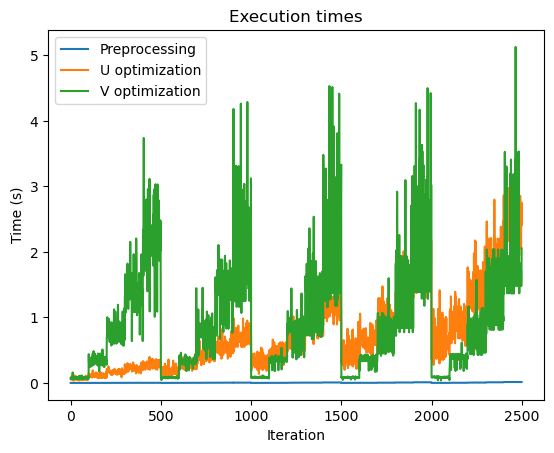

In [118]:
# Plot the preprocessing times with label for legend
plt.plot(preproc_times, label='Preprocessing')

# Plot the U optimization times with label for legend
plt.plot(U_times, label='U optimization')

# Plot the V optimization times with label for legend
plt.plot(V_times, label='V optimization')

plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.title('Execution times')

plt.legend()
plt.show()


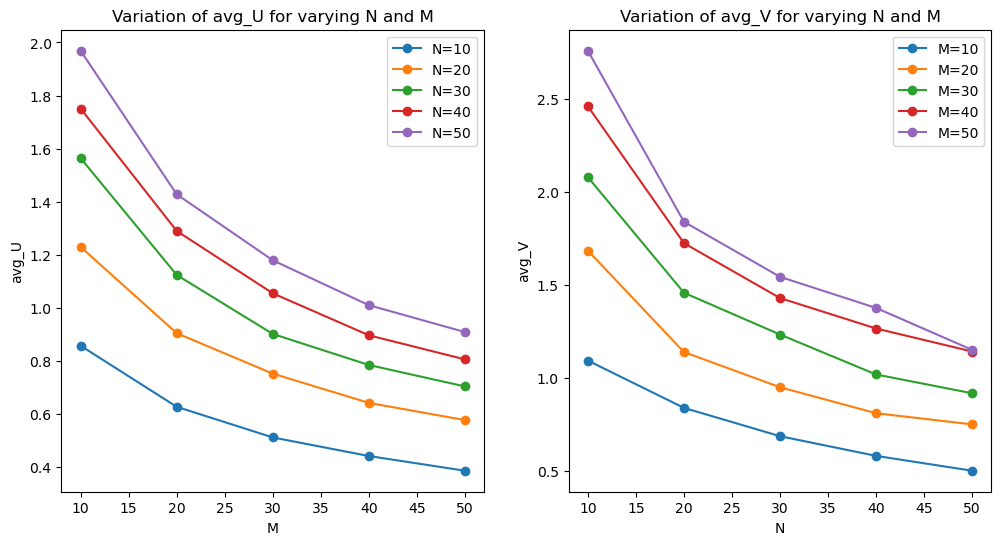

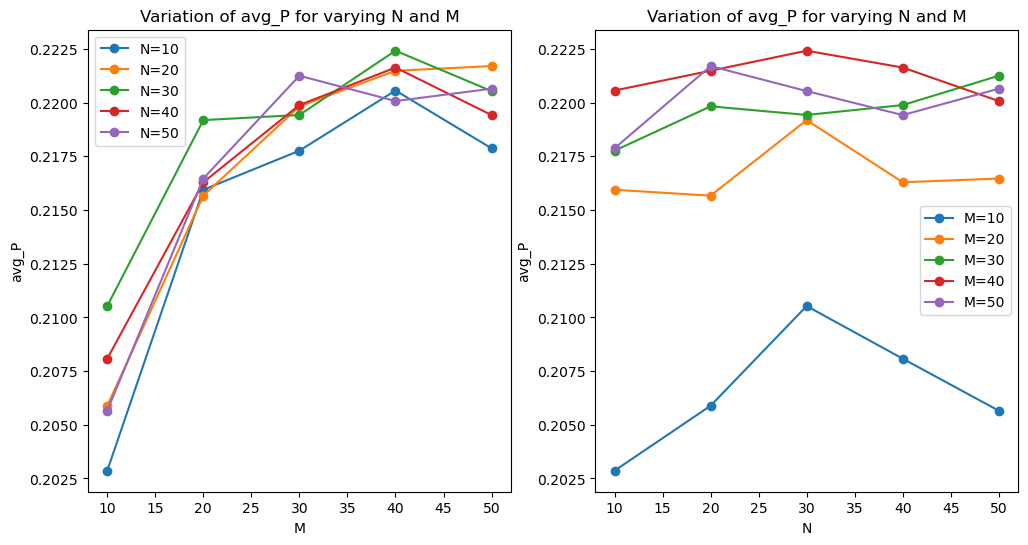

In [119]:
# Create a DataFrame from the data
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V', 'avg_P'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# For each unique value of N in the DataFrame
for n in df['N'].unique():
    # Select the rows where N equals the current unique value
    df_m = df[df['N'] == n]
    # Plot M against avg_U (scaled by sqrt(M)) on the first subplot
    ax1.plot(df_m['M'], df_m['avg_U']/np.sqrt(df_m['M']), marker='o', label=f'N={n}')

# Repeat the process for each unique value of M in the DataFrame, but plot against avg_V on the second subplot
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V']/np.sqrt(df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

# Repeat the process for avg_P
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_P']/np.sqrt(n*df_m['M']*df_m['M']), marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_P']/np.sqrt(m*m*df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_P')
ax1.set_title('Variation of avg_P for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_P')
ax2.set_title('Variation of avg_P for varying N and M')
ax2.legend()

plt.show()


# Alternating Minimization on Simulated Preference Data

In [11]:
def initialize_parameters(sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg):  
    # Generate user and item feature matrices U and V, and preference matrix X
    U, V, X = generate_U_V_R(mu, sigma_u, sigma_v, sigma, d_dim, n_users, n_movies)
    # Generate the pairwise preference matrix P
    P, _ = generate_P_BT_Luce(X, n_users)
    # Generate the pairwise comparison matrix Y
    Y = pairwise_comparisons(P)  
    # Initialize user and item feature matrices U and V
    U_init = np.random.normal(mu, sigma_u, (d_dims, n_users))
    V_init = np.random.normal(mu, sigma_v, (d_dims, n_movies))   
    
    # Store the generated and initialized values in the parameters dictionary
    parameters['U'] = U
    parameters['V'] = V
    parameters['P'] = P
    parameters['Y'] = Y
    parameters['U_result'] = U_init
    parameters['V_result'] = V_init
    parameters['lambda_reg'] = lambda_reg


In [12]:
def update_parameters(n_users, n_movies):
    # Get the current user and item feature matrices from the parameters dictionary
    U_prev = parameters['U_result']
    V_prev = parameters['V_result']
    # Get the pairwise comparison matrix Y
    Y = parameters['Y']

    # Reshape U and V to have the correct dimensions
    U_prev = U_prev.reshape((d_dim, n_users))
    V_prev = V_prev.reshape((d_dim, n_movies))

    # Minimize the loss functions for U and V using the L-BFGS-B method
    U_result = minimize(loss_U, U_prev, args=(Y, V_prev, lambda_reg, d_dim, n_users), method='L-BFGS-B')
    V_result = minimize(loss_V, V_prev, args=(Y, U_prev, lambda_reg, d_dim, n_movies), method='L-BFGS-B')
    
    # Reshape the result to have the correct dimensions
    U_result = U_result.x.reshape((d_dim, n_users))
    V_result = V_result.x.reshape((d_dim, n_movies))
    
    # Update the user and item feature matrices in the parameters dictionary
    parameters['U_result'] = U_result
    parameters['V_result'] = V_result


In [13]:
def loss(d_dim, n_users, n_movies):
    # Get the current user and item feature matrices from the parameters dictionary
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    # Get the pairwise comparison matrix Y and regularization parameter lambda
    Y = parameters['Y']
    lambda_reg = parameters['lambda_reg']

    # Calculate the loss for U and V using the loss_U and loss_V functions
    # Normalize the loss by the number of dimensions times the number of users/movies
    loss_u = loss_U(U_result, Y, V_result, lambda_reg, d_dim, n_users) /(d_dim*n_users)
    loss_v = loss_V(V_result, Y, U_result, lambda_reg, d_dim, n_movies) /(d_dim*n_movies)
    
    return loss_u, loss_v


In [15]:
def compare_results(n_users, n_movies):
    U = parameters['U']
    V = parameters['V']
    P = parameters['P']
    U_result = parameters['U_result']
    V_result = parameters['V_result']
    
    # Calculate the difference between the original and optimized U matrices using the Orthogonal Procrustes problem
    diff_norm_U = orth_procrustes(U, U_result, 1)
    
    # Calculate the difference between the original and optimized V matrices using the Orthogonal Procrustes problem
    # Note: the base of V (V_base) is used for the comparison
    V_base = V.T - V[:,0]
    V_result_base = V_result.T - V_result[:,0]
    diff_norm_V = orth_procrustes(V_base, V_result_base, 1)
    
    # Calculate the difference between the original and optimized P matrices using the Frobenius norm
    X_result = np.matmul(U_result.T, V_result)
    P_result, _ = generate_P_BT_Luce(X_result, n_users)
    diff_norm_P = np.linalg.norm(P - P_result)
    
    return diff_norm_U, diff_norm_V, diff_norm_P


In [16]:
def alt_minimization_U_V(d_dims, n_users, n_movies):
    # Initialize the parameters
    initialize_parameters(sigma_u, sigma_v, mu, sigma, d_dims, n_users, n_movies, lambda_reg) 
    loss_u_vals = []
    loss_v_vals = []
    
    # Loop until the change in loss for U is less than 0.1
    for i in range(25): 
        if len(loss_u_vals) > 2:
            if np.abs(loss_u_vals[-1] - loss_u_vals[-2]) < 0.1:
                break
        # Update the parameters
        update_parameters(n_users, n_movies)
        
        # Calculate the loss for U and V
        loss_u, loss_v = loss(d_dim, n_users, n_movies)
        loss_u_vals.append(loss_u)
        loss_v_vals.append(loss_v) 
        
        # Print the loss values every 10 iterations
        if i % 10 == 0:
            print(f'loss_u: {loss_u}, loss_v: {loss_v}')      
                
    # Compare the original and optimized matrices
    diff_norm_U, diff_norm_V, diff_norm_P = compare_results(n_users, n_movies)
    
    return diff_norm_U, diff_norm_V, diff_norm_P, loss_u_vals, loss_v_vals


In [17]:
def norm_results_altmin(d_dim, n_users, n_movies, nb_iter):
    # Initialize the average differences and counts
    avg_U = 0
    avg_V = 0
    avg_P = 0
    n_U = 0
    n_V = 0
    n_P = 0
    
    # Loop over the number of iterations
    for i in range(nb_iter):
        # Perform the alternating minimization and get the differences and loss values
        diff_P, diff_U, diff_V, loss_u_vals, loss_v_vals = alt_minimization_U_V(d_dim, n_users, n_movies)
        
        if diff_U is not np.nan:
            avg_U += diff_U
            n_U += 1
        if diff_V is not np.nan:
            avg_V += diff_V
            n_V += 1
        if diff_P is not np.nan:
            avg_P += diff_P
            n_P += 1
    
    # Calculate the average differences
    avg_U /= n_U
    avg_V /= n_V
    avg_P /= n_P
    
    return avg_U, avg_V, avg_P, loss_u_vals, loss_v_vals


In [ ]:
# Define the values of N and M to test
N_vals = [10, 20, 30, 40, 50]
M_vals = [10, 20, 30, 40, 50]

# Define the number of iterations to run for each combination of N and M
nb_iter = 5

preproc_times = []
U_times = []
V_times = []
data = []

# Loop over the values of N
for i in range(len(N_vals)):
    # Loop over the values of M
    for j in range(len(M_vals)):
        # Print the current values of N and M
        print(f'N: {N_vals[i]}, M: {M_vals[j]}')
        
        # Run the alternating minimization and get the average differences and loss values
        avg_U, avg_V, avg_P, loss_u_vals, loss_v_vals = norm_results_altmin(d_dim, N_vals[i], M_vals[j], nb_iter)
        
        row = [N_vals[i], M_vals[j], avg_U, avg_V, avg_P]
        data.append(row)
        U_times.append(loss_u_vals)
        V_times.append(loss_v_vals)


In [ ]:
for i in range(len(U_times)):
    
    # Plot the loss values for the current combination of N and M
    plt.plot(U_times[i], label='U')
    plt.legend()
    plt.show()


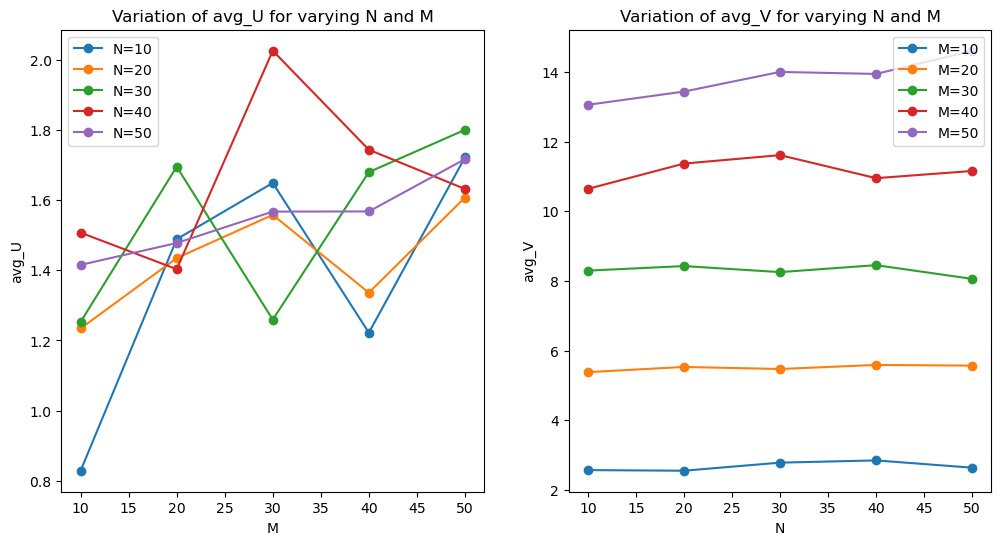

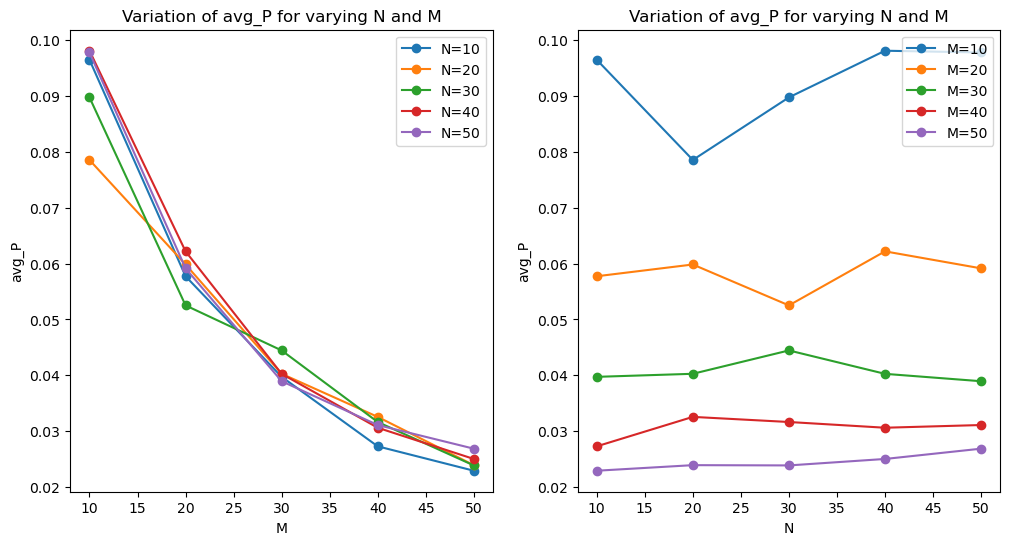

In [21]:
# Create a DataFrame from the data list
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V', 'avg_P'])

# Create subplots for the first set of plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot avg_U as a function of M for each unique N
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U']/np.sqrt(df_m['M']), marker='o', label=f'N={n}')

# Plot avg_V as a function of N for each unique M
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V']/np.sqrt(df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

# Create subplots for the second set of plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot avg_P as a function of M for each unique N
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_P']/np.sqrt(n*df_m['M']*df_m['M']), marker='o', label=f'N={n}')

# Plot avg_P as a function of N for each unique M
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_P']/np.sqrt(m*m*df_n['N']), marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_P')
ax1.set_title('Variation of avg_P for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_P')
ax2.set_title('Variation of avg_P for varying N and M')
ax2.legend()

plt.show()
